# Mesure et prédiction de la dégradation de l'habitat - Code Python

## Librairies nécessaires

In [4]:
import os
import numpy as np
import pandas as pd
import random as rd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn import tree
from IPython.display import Image  
import pydotplus
import matplotlib.pyplot as pt
%matplotlib inline
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import NearestNeighbors

from insalubrite.config_insal import path_output

# 1. Visualisation des données

##### On importe la base de donnée et en affiche les premières colonnes.

In [10]:
#Importation de la base de données avec pandas

insalubrite = pd.read_csv(os.path.join(path_output, 'Insalubrite_corrige3.csv'), sep = ";", encoding = "unicode_escape")
del insalubrite['Unnamed: 0']
print(len(insalubrite))
insalubrite[:5]

17367


,affaire_id,code_cadastre,code_postal,infractiontype_id,L_PDNIV0,L_PDNIV1,L_PDNIV2,B_PUBLIC,NB_BAT,NB_LG,...,RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale,Sans domicile fixe,Structure d??hÇ¸bergement,Sous locataire ou hÇ¸bergÇ¸ dans un logement Çÿ titre temporaire,Locataire dans un logement social,Louez solidaire et sans risque,Dans un squat,TOT_PROP,TOT_LOC,TOTAL_DEM
0,69,751010AR0027,75101,30.0,Multi-propriÇ¸taire,Multi-propriÇ¸taire,CopropriÇ¸tÇ¸,N,2.0,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71,751010AR0099,75101,19.0,Multi-propriÇ¸taire,Multi-propriÇ¸taire,CopropriÇ¸tÇ¸,N,2.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,72,751010AO0154,75101,30.0,Multi-propriÇ¸taire,Multi-propriÇ¸taire,CopropriÇ¸tÇ¸,N,1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2.0,2.0
3,113,751010AX0031,75101,30.0,Multi-propriÇ¸taire,Multi-propriÇ¸taire,CopropriÇ¸tÇ¸,N,1.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,143,751010AY0054,75101,30.0,Multi-propriÇ¸taire,Multi-propriÇ¸taire,CopropriÇ¸tÇ¸,N,2.0,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Matrice des corrélations

###### Afin d'avoir une première idée des différentes liaisons entre les variables, on trace la heatmap de la matrice des corrélations.

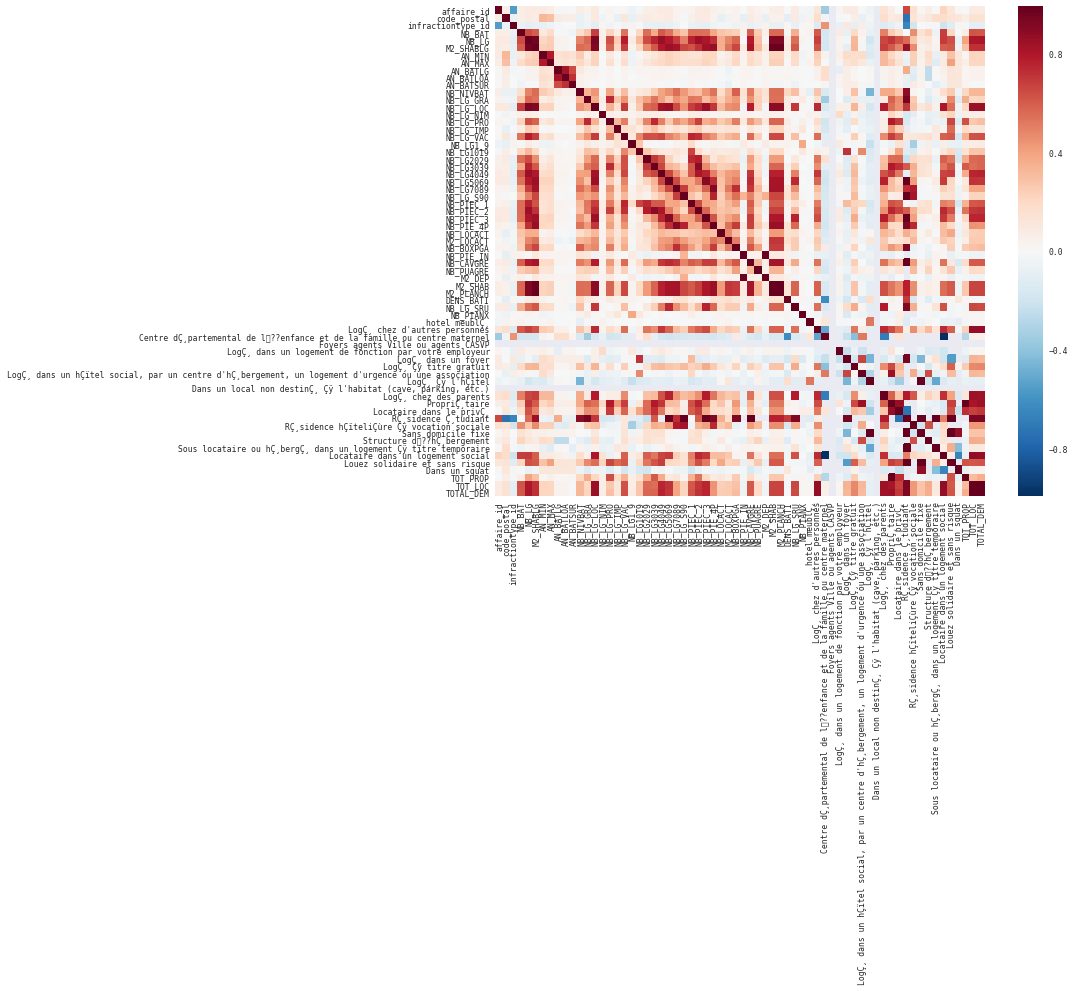

In [8]:
df1 = insalubrite.copy()

# Matrice des corrélations
sns.set(context="paper", font="monospace")
corrmat = df1.corr()

# matplotlib figure
f, ax = pt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square = True, ax = ax)
pt.show()
corrmat.to_csv(os.path.join(path_output, 'corrmat.csv'), sep = ",")

# 2. Préparation de la base

###### Afin de pouvoir utiliser les librairies de Machine Learning de Scikit:
     1 - On convertit les variables catégorielles (qualitatives) en variables numériques à l'aide de la librairie 
     préprocessing de Scikit Learn.
     2 - On remplace les valeurs manquantes (missing values) à l'aide de la librairie Imputer de Scikit.

##### On encode les variables catégorielles.

In [11]:
le = preprocessing.LabelEncoder()
#imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
insal = insalubrite.copy()
col = list(insalubrite)
nbcol = len(col)
for i in col:
    if type(insalubrite[i][0]) == str:
        #print("premier elt ",insalubrite[i][0])
        le.fit(insalubrite[i])
        insal[i] = le.transform(insal[i])

In [12]:
print(insal[:3])

   affaire_id  code_cadastre  code_postal  infractiontype_id  L_PDNIV0  \
0          69             38        75101               30.0         0   
1          71             45        75101               19.0         0   
2          72             18        75101               30.0         0   

   L_PDNIV1  L_PDNIV2  B_PUBLIC  NB_BAT  NB_LG    ...      \
0         6         8         0     2.0   13.0    ...       
1         6         8         0     2.0   21.0    ...       
2         6         8         0     1.0   19.0    ...       

   RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale  Sans domicile fixe  \
0                                         NaN                 NaN   
1                                         NaN                 NaN   
2                                         NaN                 NaN   

   Structure d??hÇ¸bergement  \
0                         NaN   
1                         NaN   
2                         NaN   

   Sous locataire ou hÇ¸bergÇ¸ dans un logement 

##### On remplit les données manquantes avec la stratégie de la valeur la plus fréquente.

In [13]:
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
imputed_DF = pd.DataFrame(imp.fit_transform(insal))
imputed_DF.columns = insal.columns
imputed_DF.index = insal.index

In [13]:
print(imputed_DF[:3])

   affaire_id  code_cadastre  code_postal  infractiontype_id  L_PDNIV0  \
0          69             38        75101                 30         0   
1          71             45        75101                 19         0   
2          72             18        75101                 30         0   

   L_PDNIV1  L_PDNIV2  B_PUBLIC  NB_BAT  NB_LG    ...      \
0         6         8         0       2     13    ...       
1         6         8         0       2     21    ...       
2         6         8         0       1     19    ...       

   RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale  Sans domicile fixe  \
0                                           1                   1   
1                                           1                   1   
2                                           1                   1   

   Structure d??hÇ¸bergement  \
0                           1   
1                           1   
2                           1   

   Sous locataire ou hÇ¸bergÇ¸ dans un logement 

##### Comparaison entre les deux bases avant et après traitement numérique.

In [14]:
print("-------------")
print("Base insalubrite")
print("-------------")
print(insalubrite.code_cadastre[:5])
print("-------------")
print("Base insal")
print("-------------")
print(imputed_DF.code_cadastre[:5])

-------------
Base insalubrite
-------------
0    751010AR0027
1    751010AR0099
2    751010AO0154
3    751010AX0031
4    751010AY0054
Name: code_cadastre, dtype: object
-------------
Base insal
-------------
0    38.0
1    45.0
2    18.0
3    71.0
4    76.0
Name: code_cadastre, dtype: float64


# 3. Prédiction par forêts aléatoires 

##### On s'intéresse à la prédiction de la variable infractiontype_id par l'ensemble des autres variables en vue de pouvoir déterminer le type d'infraction à la salubrité du lieu de signalement avant même toute expertise de la part de l'agent. 

##### On sépare les données en variable à prédire et variables prédictives.

In [16]:
X = imputed_DF.copy()
Y = X.infractiontype_id
#On sépare la variable à prédire des variables d'entrées
X = X.drop('infractiontype_id',axis=1)
#On enlève la variable affaire_id sans intérêt pour la prédiction
X = X.drop('affaire_id', axis=1)
# print(X[:5])

In [73]:
#print(X[:5])

   code_cadastre  code_postal  L_PDNIV0  L_PDNIV1  L_PDNIV2  B_PUBLIC  NB_BAT  \
0             38        75101         0         6         8         0       2   
1             45        75101         0         6         8         0       2   
2             18        75101         0         6         8         0       1   
3             71        75101         0         6         8         0       1   
4             76        75101         0         6         8         0       2   

   NB_LG  M2_SHABLG  AN_MIN    ...      \
0     13        856    1750    ...       
1     21       1285    1880    ...       
2     19        356    1880    ...       
3      6        386    1880    ...       
4     21       1237    1800    ...       

   RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale  Sans domicile fixe  \
0                                           1                   1   
1                                           1                   1   
2                                           1        

###### Exemple visuel d'un arbre de prédiction avec une longueur maximum de 3

In [17]:
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(X, Y)
with open("tree_exemple.dot", 'w') as f:
    f = tree.export_graphviz(clf, feature_names = X.columns, out_file=f)

### Construction de l'estimateur par forêts aléatoires.

###### Paramètres optionnels importants de la fonction RandomForestClassifier:
    - n_estimators : The number of trees in the forest.
    - criterion : The function to measure the quality of a split. 
        Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain. 
    - max_features : The number of features to consider when looking for the best split.
        If “auto”, then max_features=sqrt(n_features).
    - max_depth : The maximum depth of the tree.
    - min_samples_split : The minimum number of samples required to split an internal node.
    - min_samples_leaf : The minimum number of samples required to be at a leaf node
    - min_impurity_split : Threshold for early stopping in tree growth. A node will split if its impurity is above the threshold, otherwise it is a leaf.
    - bootstrap : Whether bootstrap samples are used when building trees.
    - oob_score :Whether to use out-of-bag samples to estimate the generalization accuracy (out-of-bag estimate are samples not used for training due to bagging procedure.)

In [18]:
clf = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=27,min_samples_split = 2,min_samples_leaf = 1,
                             max_features='auto', bootstrap=True, oob_score=True)
clf = clf.fit(X, Y)
insalubrite_prediction = clf.predict(X)

In [19]:
print(insalubrite_prediction[:6])
print(Y[:6])

[ 30.  19.  11.  30.  30.  30.]
0    30.0
1    19.0
2    30.0
3    30.0
4    30.0
5    30.0
Name: infractiontype_id, dtype: float64


##### Etablissement du score de prédiction avec les deux indicateurs.

In [20]:
compteur_tot = 0 #compte le nombre de bonnes prédictions
compteur_part = 0 #compte le nombre de bonnes prédictions menant à une intervention
nb_insalubrite = 0 #compte le nombre de situations d'insalubrité

for i in range(len(Y)):
    if Y[i] !=30:
        nb_insalubrite+=1
    if Y[i]==insalubrite_prediction[i]:
        compteur_tot +=1
        if Y[i]!=30:
            compteur_part+=1
print("Pourcentage de bonnes prédictions : ",compteur_tot/len(Y))
print("Pourcentage de bonnes prédictions en cas d'intervention :", compteur_part/nb_insalubrite) 

Pourcentage de bonnes prédictions :  0.7052455806990269
Pourcentage de bonnes prédictions en cas d'intervention : 0.6416420413704975


###### Classement des features par ordres d'importance.

In [29]:
#Liste des coefficients de pondérations devant les features dans la prédiction
ponderation = clf.feature_importances_
cols = X.columns.values
features = [(cols[i], ponderation[i]) for i in range(len(cols))]
print(sorted(features, key=lambda features: features[1]))

[('Foyers agents Ville ou agents CASVP', 0.0), ("Dans un local non destinÇ¸ Çÿ l'habitat (cave, parking, etc.)", 0.0), ('Centre dÇ¸partemental de l\x83??enfance et de la famille ou centre maternel', 9.0952610678120034e-06), ('RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale', 1.6309037391239755e-05), ('Dans un squat', 3.0802446507616268e-05), ('RÇ¸sidence Ç¸tudiant', 6.7545823738567704e-05), ("LogÇ¸ Çÿ l'hÇïtel", 7.3491206953598117e-05), ('Louez solidaire et sans risque', 8.2818892432758408e-05), ('LogÇ¸ dans un logement de fonction par votre employeur', 0.00018175837811170757), ('Structure d\x83??hÇ¸bergement', 0.00030046451119471304), ('Sans domicile fixe', 0.00030481412587736375), ('LogÇ¸ Çÿ titre gratuit', 0.00031354392901913495), ("LogÇ¸ dans un hÇïtel social, par un centre d'hÇ¸bergement, un logement d'urgence ou une association", 0.00036578325251987432), ('LogÇ¸ dans un foyer', 0.0004152967230248917), ('PropriÇ¸taire', 0.00061912412438679587), ('Sous locataire ou hÇ¸bergÇ¸ dans un log

# 4. Prédiction par K-means

### Séparation des données en base test et base d'apprentissage.

In [45]:
X_train, X_test = train_test_split(imputed_DF, test_size = 0.2)

In [72]:
X_test[:3]

,code_cadastre,code_postal,L_PDNIV0,L_PDNIV1,L_PDNIV2,B_PUBLIC,NB_BAT,NB_LG,M2_SHABLG,AN_MIN,...,RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale,Sans domicile fixe,Structure d??hÇ¸bergement,Sous locataire ou hÇ¸bergÇ¸ dans un logement Çÿ titre temporaire,Locataire dans un logement social,Louez solidaire et sans risque,Dans un squat,TOT_PROP,TOT_LOC,TOTAL_DEM
3164,2528,75111,0,6,8,0,2,25,699,1800,...,1,1,1,1,1,1,1,0,4,4
2258,7426,75118,1,12,20,1,1,4,281,2011,...,1,1,1,1,1,1,1,0,2,2
8938,9347,75120,1,7,15,1,18,462,23130,1934,...,1,1,1,1,45,1,1,0,85,85


##### On sépare les données en variable à prédire et variables prédictives.


In [47]:
Y_train = X_train.infractiontype_id
Y_test = X_test.infractiontype_id
#On sépare la variable à prédire des variables d'entrées
X_test = X_test.drop('infractiontype_id',axis=1)
X_train = X_train.drop('infractiontype_id',axis=1)
#On enlève la variable affaire_id sans intérêt pour la prédiction
X_test = X_test.drop('affaire_id',axis=1)
X_train = X_train.drop('affaire_id',axis=1)

##### On sépare les données en variable à prédire et variables prédictives.

In [12]:
X = imputed_DF.copy()
Y = X.infractiontype_id
#On sépare la variable à prédire des variables d'entrées
X = X.drop('infractiontype_id',axis=1)
#On enlève la variable affaire_id sans intérêt pour la prédiction
X = X.drop('affaire_id', axis=1)
# print(X[:5])

###### Paramètres optionnels importants de la fonction KNeighborsClassifier:
    - n_neighbors : Number of neighbors to use by default for k_neighbors queries.
    - weight : weight function used in prediction (uniform, distance). weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.
    - metric : the distance metric to use for the tree (Euclidean )
    - n_jobs : The number of parallel jobs to run for neighbors search. If -1, then the number of jobs is set to the number of CPU cores. 

In [18]:
KNC = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',p=2, metric = 'minkowski')
KNC.fit(X, Y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [57]:
KNC.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [1]:
# insalubrite_prediction = KNC.predict(X_test)

In [19]:
insalubrite_prediction = KNC.predict(X)

##### Etablissement du score de prédiction avec les deux indicateurs.

In [63]:
type(insalubrite_prediction)

numpy.ndarray

In [64]:
type(Y_test)

pandas.core.series.Series

In [71]:
X_test[:], Y_test[:10], insalubrite_prediction[:10]

(       code_cadastre  code_postal  L_PDNIV0  L_PDNIV1  L_PDNIV2  B_PUBLIC  \
 3164            2528        75111         0         6         8         0   
 2258            7426        75118         1        12        20         1   
 8938            9347        75120         1         7        15         1   
 15038           6495        75117         0         6         8         0   
 5408             889        75105         0         6         8         0   
 
        NB_BAT  NB_LG  M2_SHABLG  AN_MIN    ...      \
 3164        2     25        699    1800    ...       
 2258        1      4        281    2011    ...       
 8938       18    462      23130    1934    ...       
 15038       3     21        383    1880    ...       
 5408        2     11        563    1875    ...       
 
        RÇ¸sidence hÇïteliÇùre Çÿ vocation sociale  Sans domicile fixe  \
 3164                                            1                   1   
 2258                                            1

In [76]:
Y_test.index

Int64Index([ 3164,  2258,  8938, 15038,  5408,  5598, 13247, 15719,  8482,
            16018,
            ...
             1689, 13647, 13955, 16252, 12870, 10781, 10135, 10375,  2482,
            14131],
           dtype='int64', length=3474)

In [2]:
# compteur_tot = 0 #compte le nombre de bonnes prédictions
# compteur_part = 0 #compte le nombre de bonnes prédictions menant à une intervention
# nb_insalubrite = 0 #compte le nombre de situations d'insalubrité
# index = Y_test.index
# for i in range(len(Y_test)):
#     if Y_test[index[i]] !=30:
#         nb_insalubrite+=1
#     if Y_test[index[i]]==insalubrite_prediction[i]:
#         compteur_tot +=1
#         if Y_test[index[i]]!=30:
#             compteur_part+=1
# print("Pourcentage de bonnes prédictions : ",compteur_tot/len(Y))
# print("Pourcentage de bonnes prédictions en cas d'intervention :", compteur_part/nb_insalubrite) 

In [21]:
compteur_tot = 0 #compte le nombre de bonnes prédictions
compteur_part = 0 #compte le nombre de bonnes prédictions menant à une intervention
nb_insalubrite = 0 #compte le nombre de situations d'insalubrité

for i in range(len(Y)):
    if Y[i] !=30:
        nb_insalubrite+=1
    if Y[i]==insalubrite_prediction[i]:
        compteur_tot +=1
        if Y[i]!=30:
            compteur_part+=1
print("Pourcentage de bonnes prédictions : ",compteur_tot/len(Y))
print("Pourcentage de bonnes prédictions en cas d'intervention :", compteur_part/nb_insalubrite) 

Pourcentage de bonnes prédictions :  0.6963206080497495
Pourcentage de bonnes prédictions en cas d'intervention : 0.6629662167558502
